In [4]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# mannequin_path = os.path.join('../','eventsData/training/mannequin')
# # not_mannequin_path = os.path.join('../','not_mannequin_filter')

# mannequin_img_path = [os.path.join(mannequin_path,x) for x in os.listdir(mannequin_path)]
# # not_mannequin_img_path = [os.path.join(not_mannequin_path,x) for x in os.listdir(not_mannequin_path)]

# print(mannequin_img_path[:5])
# # print(not_mannequin_img_path[:5])

# random.shuffle(mannequin_img_path)
# random.shuffle(mannequin_img_path)
# # random.shuffle(not_mannequin_img_path)
# # random.shuffle(not_mannequin_img_path)

# print(mannequin_img_path[:5])
# print(not_mannequin_img_path[:5])

In [3]:
# train_mannequin_img, test_mannequin_img = train_test_split(mannequin_img_path,test_size = 0.20,random_state=42)

In [4]:
train_datagen = IDG(rescale=1/255,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True,shear_range=0.2,fill_mode='nearest')
val_datagen = IDG(rescale=1/255)
test_datagen = IDG(rescale=1/255)

train_path = '../EventsFrame_19012020/upscaled_data_TrainTestVal/training'
val_path = '../EventsFrame_19012020/upscaled_data_TrainTestVal/validation'
test_path = '../EventsFrame_19012020/upscaled_data_TrainTestVal/testing'
shape = (64,64,3)

In [5]:
train_generator = train_datagen.flow_from_directory(train_path,target_size=(shape[0],shape[1]),batch_size=16,class_mode='categorical',shuffle=True,color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(shape[0],shape[1]),batch_size=16,class_mode='categorical',shuffle=True,color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(shape[0],shape[1]),batch_size=32,class_mode='categorical')


Found 4137 images belonging to 2 classes.
Found 1774 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [6]:
a,b = train_generator.next()

In [7]:
a[1].max()

0.5769967

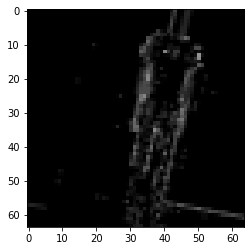

In [8]:
plt.imshow(a[1],cmap='gray')

In [9]:
efficientB2_model = ResNet50V2(include_top=False,weights='imagenet',input_shape=shape)
efficientB2_model.trainable=False
x = GlobalAveragePooling2D()(efficientB2_model.output)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2,activation='softmax')(x)

model = Model(efficientB2_model.input,x)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [10]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [11]:
history=model.fit(train_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
259/259 [==============================] - 8s 29ms/step - loss: 0.3410 - accuracy: 0.8608 - val_loss: 0.1181 - val_accuracy: 0.9622
Epoch 2/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1704 - accuracy: 0.9364 - val_loss: 0.0787 - val_accuracy: 0.9758
Epoch 3/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1543 - accuracy: 0.9391 - val_loss: 0.0646 - val_accuracy: 0.9791
Epoch 4/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1178 - accuracy: 0.9517 - val_loss: 0.0548 - val_accuracy: 0.9837
Epoch 5/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1270 - accuracy: 0.9538 - val_loss: 0.0495 - val_accuracy: 0.9848
Epoch 6/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1147 - accuracy: 0.9601 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 7/20
259/259 [==============================] - 7s 27ms/step - loss: 0.1084 - accuracy: 0.9616 - val_loss: 0.0507 - val_accuracy: 0.9837

In [12]:
model.save('ResNet50V2_softmax_Synthetic_Upscale_Frame.h5')

In [ ]:
tf.saved_model.save(model,"mobilenetV2_softmax_GM_rescale")

In [ ]:
# from tensorflow.keras.models import load_model
# model_import = load_model('mobilenetV2.h5')